# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

In [11]:
from pyproj import _datadir, datadir

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [3]:
from shapely.geometry import Polygon

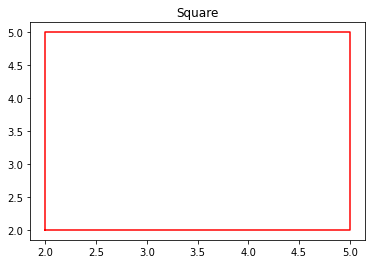

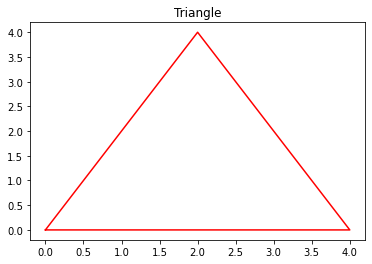

In [4]:
import matplotlib.pyplot as plt
square = Polygon([(2,2), (2,5), (5,5), (5,2)])
triangle = Polygon([(0,0), (4,0), (2,4)])

from shapely.geometry.polygon import LinearRing, Polygon

x,y = square.exterior.xy
x1,y1 = triangle.exterior.xy

# Plot Square
plt.plot(x,y, color='red')
plt.title('Square')
plt.show()
# Plot Triangle
plt.plot(x1,y1, color='red')
plt.title('Triangle')
plt.show()


> **Ex. 6.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

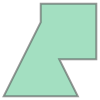

In [5]:
# Spatial difference of square substracted triangle
square.difference(triangle)

# The union of square and triangle
square.union(triangle)

> **Ex. 6.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

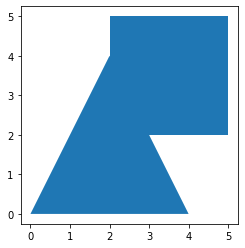

In [15]:
from geopandas import GeoSeries

s = gpd.GeoSeries([square, triangle])
s.plot()

### Part 9.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands). you can use the `unary_union` method for GeoSeries.

In [183]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"

# Loading the municipalities data 
kommuner = gpd.read_file(url)
print(kommuner.head())

#Finding the current CRS:
# : Geographic 2D CRS: EPSG:4326
# Area of use: name: World
# Axis info [ellipsoidal]:  Lat[north]: Geodetic latitude (degree), Lon[east]: Geodetic longitude (degree)
kommuner.crs

  KOMKODE     KOMNAVN                                           geometry
0    0766   Hedensted  POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...
1    0766   Hedensted  POLYGON Z ((10.06198 55.83301 -999.00000, 10.0...
2    0561     Esbjerg  POLYGON Z ((8.59656 55.53506 -999.00000, 8.601...
3    0849  Jammerbugt  POLYGON Z ((9.78314 57.07319 -999.00000, 9.781...
4    0849  Jammerbugt  POLYGON Z ((9.19738 57.13868 -999.00000, 9.207...


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [184]:
import pyproj
pyproj.Proj("+init=epsg:25832")

C:\Users\Christian\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Proj('+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs', preserve_units=True)

In [185]:
# Creating the geoseries
s_921 = gpd.GeoSeries(kommuner['geometry'])

# Changing the CRS to meter based system
kommuner.to_crs({'init':'epsg:25832'}, inplace=True)
# New CRS: ETRS89 / UTM zone 32N, Area of use: Europe - 6°E to 12°E and ETRS89 by country
# Axis info: E[east]: Easting (metre), N[north]: Northing (metre)
print(kommuner.crs)

# Finding the largest Danish municipalities
sizes = kommuner.groupby('KOMNAVN').geometry.apply(lambda d: d.unary_union.area)
print(" ")
print(sizes.nlargest(3))

C:\Users\Christian\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


+init=epsg:25832 +type=crs
 
KOMNAVN
Ringkøbing-Skjern    1.494151e+09
Viborg               1.419631e+09
Herning              1.323127e+09
Name: geometry, dtype: float64


(419120.45001907204, 915342.5495994855, 6032160.249990183, 6419838.749997308)

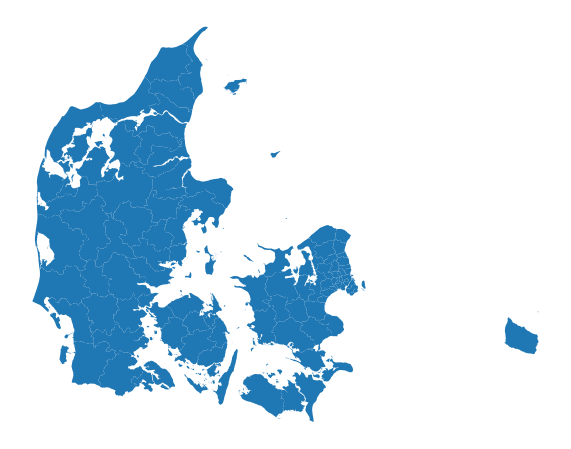

In [186]:
# Plotting the entire map
import matplotlib.pyplot as plt
kommuner.plot(figsize=(14,8))
plt.axis('off')

Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [188]:
kommuner.columns = kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

# Visualizing the changes
kommuner.head()

,komkode,komnavn,geometry,regionskode,regionsnavn
0,0766,Hedensted,"POLYGON Z ((528116.000 6190641.000 -999.000, 5...",1082,Region Midtjylland
1,0766,Hedensted,"POLYGON Z ((566517.000 6188004.430 -999.000, 5...",1082,Region Midtjylland
2,0561,Esbjerg,"POLYGON Z ((474537.000 6154409.000 -999.000, 4...",1083,Region Syddanmark
3,0849,Jammerbugt,"POLYGON Z ((547480.000 6325805.000 -999.000, 5...",1081,Region Nordjylland
4,0849,Jammerbugt,"POLYGON Z ((511946.000 6332841.000 -999.000, 5...",1081,Region Nordjylland


> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [189]:
# Sealand
sealand = kommuner['regionsnavn'].isin(['Region Hovedstaden', 'Region Sjælland']) 

# Not in Bornholm
not_bornholm = ~kommuner['komnavn'].isin(['Bornholm', 'Christiansø'])

# Combined boolean series
combined = sealand & not_bornholm

sealand_dataframe = kommuner[combined]
sealand_dataframe.head()

,komkode,komnavn,geometry,regionskode,regionsnavn
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden
16,0260,Halsnæs,"POLYGON Z ((685760.650 6206386.190 -999.000, 6...",1084,Region Hovedstaden
17,0260,Halsnæs,"POLYGON Z ((667293.000 6231338.000 -999.000, 6...",1084,Region Hovedstaden
18,0187,Vallensbæk,"POLYGON Z ((713579.000 6168252.000 -999.000, 7...",1084,Region Hovedstaden
19,0187,Vallensbæk,"POLYGON Z ((714395.930 6168389.980 -999.000, 7...",1084,Region Hovedstaden


> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

In [190]:
# Commented on above

# Information presented here:
kommuner.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 6°E to 12°E and ETRS89 by country
- bounds: (6.0, 38.76, 12.0, 83.92)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [108]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

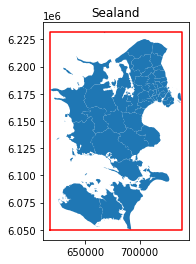

,komkode,komnavn,geometry,regionskode,regionsnavn
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden
16,0260,Halsnæs,"POLYGON Z ((685760.650 6206386.190 -999.000, 6...",1084,Region Hovedstaden
17,0260,Halsnæs,"POLYGON Z ((667293.000 6231338.000 -999.000, 6...",1084,Region Hovedstaden
18,0187,Vallensbæk,"POLYGON Z ((713579.000 6168252.000 -999.000, 7...",1084,Region Hovedstaden
19,0187,Vallensbæk,"POLYGON Z ((714395.930 6168389.980 -999.000, 7...",1084,Region Hovedstaden
...,...,...,...,...,...
302,0370,Næstved,"POLYGON Z ((672808.000 6113856.000 -999.000, 6...",1085,Region Sjælland
303,0370,Næstved,"POLYGON Z ((673235.000 6111921.000 -999.000, 6...",1085,Region Sjælland
304,0370,Næstved,"POLYGON Z ((670440.000 6118920.000 -999.000, 6...",1085,Region Sjælland
305,0370,Næstved,"POLYGON Z ((669456.000 6117697.000 -999.000, 6...",1085,Region Sjælland


In [191]:
# Extra : plotting a square around sealand in order to understand df.bounds

# sealand_dataframe.bounds

from shapely.geometry import Point, Polygon

# Points for smallest square around zealand
p1 = Point(min(sealand_dataframe.bounds['minx']), min(sealand_dataframe.bounds['miny']))
p2 = Point(min(sealand_dataframe.bounds['minx']), max(sealand_dataframe.bounds['maxy']))
p3 = Point(max(sealand_dataframe.bounds['maxx']), max(sealand_dataframe.bounds['maxy']))
p4 = Point(max(sealand_dataframe.bounds['maxx']), min(sealand_dataframe.bounds['miny']))

s_square = Polygon([p1,p2,p3,p4])
s_x,s_y = s_square.exterior.xy

# Plot Square around Sealand
sealand_dataframe.plot()
plt.plot(s_x,s_y, color='red')
plt.title('Sealand')
plt.show()


+proj=utm +ellps=GRS80 +no_defs +units=m +zone=32 +type=crs


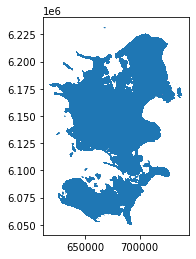

In [245]:
import pandas as pd
sealand_dataframe = sealand_dataframe.to_crs({'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32})
print(sealand_dataframe.crs)

# extracting the extreme values
min_x = min(sealand_dataframe.bounds['minx'])
max_x = max(sealand_dataframe.bounds['maxx'])
min_y = min(sealand_dataframe.bounds['miny'])
max_y = max(sealand_dataframe.bounds['maxy'])

# create thhe pairs
e = []
n = []

# Computing the coordinates (where the step size is 500)
for x in np.arange(min_x, max_x, 500):
    for y in np.arange(min_y, max_y, 500):
        e.append(x)
        n.append(y)
        
# Creating the pais of pairs (𝑒,𝑛) of the lower left corner in a 500x500 square
e_n = zip(e,n)
e_n = list(e_n)
e_n = pd.DataFrame(e_n, columns=['e', 'n'])
square_df = cell_coords_to_polygons(e_n, x='e', y='n', dist=500, crs=dk_crs)
square_df = gpd.sjoin(sealand_dataframe, square_df)

# Plotting:
square_df.plot()
plt.show()

> **Ex. 9.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

In [194]:
from sklearn.neighbors import KNeighborsRegressor
price_gdf = gpd.read_file('houseprices.GeoJSON')

In [251]:
for year in np.unique(price_gdf.sale_year):
    # Slicing in terms of extracting the relevant year, and the avg_price range
    price_gdf_year = price_gdf[(price_gdf['sale_year']==i) & (price_gdf['price_area'] >= 1000)\
                                      & (price_gdf['price_area'] <= 120000)]
    # Extracting the relevant columns
    price_gdf_year = price_gdf_year.loc[:,['sale_year', 'e', 'n', 'price_area']]
    
    # drop rows with missing data
    price_gdf_year.dropna()
    
    # Fitting an K-Nearest neighbors algorithm
    features = price_gdf_year.loc[:,['e', 'n']]
    y = price_gdf_year.loc[:,['price_area']]
    knn = KNeighborsRegressor()
    knn.fit(features, y)
    
    # Make predictions and store results
    en = square_df.loc[:,['e','n']]
    preds = knn.predict(en)
    preds = preds + 250
    square_df[f'p_{year}'] = np.log10(preds)
   

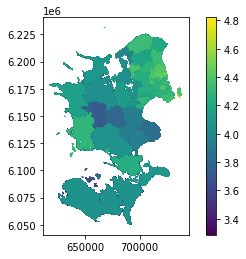

In [256]:
# Plotting the grid data coloring the grids by their predicted square meter price in 2012
fig, ax = plt.subplots(1, 1)
square_df.plot(column='p_2012', ax=ax, legend=True)
plt.show()